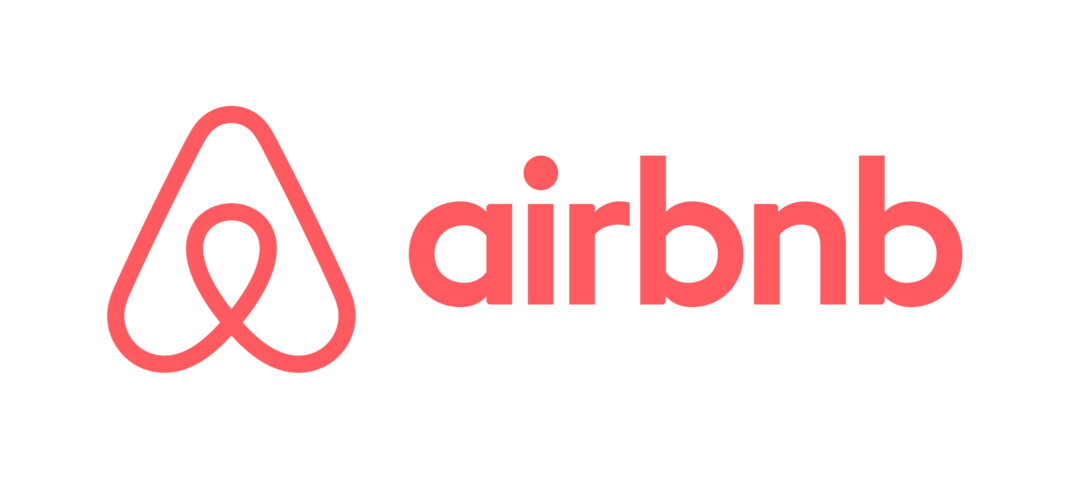

In [2]:
Image('img/airbnb.png')

<h1>Airbnb New User Bookings</h1>

<h3>Where will a new guest book their first travel experience?<h/3>

Instead of waking to overlooked "Do not disturb" signs, Airbnb travelers find themselves rising with the birds in a whimsical treehouse, having their morning coffee on the deck of a houseboat, or cooking a shared regional breakfast with their hosts.

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

In this business problem, Airbnb launched a challenge to predict in which country a new user will make his or her first booking.

<h3>Understanding the business problem</h3><br>

 - Problem Propose:
 
      - Prediction of the first destination a new user will choose.
            
            
  - What kind of Airbnb business model?
 
      - Marketplace (Connect people offering accommodation with people looking for accommodation)

<h1>Index</h1>

 - 0.0. IMPORTS
 - 1.0. DATA DESCRIPTION
 - 2.0. DATA FILTERING
 - 3.0. EXPLORATORY DATA ANALYSIS
 - 4.0. DATA PREPARATION
 - 5.0. FEATURE SELECTION
 - 6.0. MACHINE LEARNING MODELLING
 - 7.0. HYPERPARAMETER FINE TUNING
 - 8.0. TRANSLATION AND MODEL'S INTERPERTATION
 - 9.0 MODEL DEPLOY TO PREDICTION

# 0.0. IMPORTS

In [1]:
import warnings
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sns

from random                  import choices

from IPython.core.display    import HTML
from IPython.display         import Image

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import OneHotEncoder
from sklearn.metrics         import accuracy_score, balanced_accuracy_score
from sklearn.metrics         import cohen_kappa_score, classification_report

from scikitplot.metrics      import plot_confusion_matrix

from keras import models     as ml
from keras import layers     as l
from scipy import stats      as ss

warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [3]:
def cramer_v(x, y):
    
    cm = pd.crosstab( x, y ).values    
    n = cm.sum()
    r, k = cm.shape 
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k - 1) * (r - 1) / (n - 1) )
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt( (chi2corr / n) / min( kcorr - 1, rcorr - 1 ) )  


    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [5]:
df_raw = pd.read_csv('data/training_users.csv', low_memory=True)
df_raw.shape

(213451, 16)

In [7]:
df_session = pd.read_csv('data/sessions.csv', low_memory=True)
df_session.shape

(10567737, 6)

# 1.0. DATA DESCRIPTION

In [8]:
df1 = df_raw.copy()

In [9]:
df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## 1.1. Data Dimesion

In [10]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 213451
Number of columns: 16


In [11]:
print(f'Number of rows: {df_session.shape[0]}')
print(f'Number of columns: {df_session.shape[1]}')

Number of rows: 10567737
Number of columns: 6


<br/>

In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

<h2>File descriptions</h2>

**train_users.csv** - the training set of users<br>
**test_users.csv** - the test set of users
 - id: user id
 - date_account_created: the date of account creation
 - timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or  - date_first_booking because a user can search before signing up
 - date_first_booking: date of first booking
 - gender
 - age
 - signup_method
 - signup_flow: the page a user came to signup up from
 - language: international language preference
 - affiliate_channel: what kind of paid marketing
 - affiliate_provider: where the marketing is e.g. google, craigslist, other
 - first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
 - signup_app
 - first_device_type
 - first_browser
 - country_destination: this is the target variable you are to predict

**sessions.csv** - web sessions log for users
 - user_id: to be joined with the column 'id' in users table
 - action
 - action_type
 - action_detail
 - device_type
 - secs_elapsed

**countries.csv** - summary statistics of destination countries in this dataset and their locations<br>
**age_gender_bkts.csv** - summary statistics of users' age group, gender, country of destination<br>
**sample_submission.csv** - correct format for submitting your predictions

 - Data Source: https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/overview <br/>

## 1.2. Data Types

In [12]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [13]:
df_session.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. Check N/A's

In [14]:
df1.isna().sum() / len( df1 )

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [15]:
df_session.isna().sum() / len( df_session )

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4. Fillout N/A's

In [16]:
# date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime( '%Y-%m-%d' ) 
df1['date_first_booking'] = df1['date_first_booking'].fillna( date_first_booking_max )

# age
df1 = df1[(df1['age'] > 16) & (df1['age'] < 120)]
average_age = df1['age'].mean().astype( int )
df1['age'] = df1['age'].fillna( average_age )

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

In [17]:
# user_id
df_session = df_session[~df_session['user_id'].isna()]

# action
df_session = df_session[~df_session['action'].isna()]

# action_type
df_session = df_session[~df_session['action_type'].isna()]

# action_detail
df_session = df_session[~df_session['action_detail'].isna()]

# secs_elapsed
df_session = df_session[~df_session['secs_elapsed'].isna()]

In [18]:
df1.isna().sum() / len(df1)

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [19]:
df_session.isna().sum() / len(df_session)

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.5. Change Data Type

In [20]:
# date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( int )

In [21]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6. Check Balanced Data

In [22]:
# value_counts in percentage for each country
df1['country_destination'].value_counts( normalize=True )

NDF      0.447166
US       0.391942
other    0.061259
FR       0.029924
IT       0.016426
GB       0.014338
ES       0.013743
CA       0.008678
DE       0.006859
NL       0.004853
AU       0.003532
PT       0.001280
Name: country_destination, dtype: float64

## 1.7. Descriptive Analysis

In [23]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [24]:
df_session.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

In [25]:
# Users Dataset
cat_attr = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
num_attr = df1.select_dtypes( include=['int64', 'float64'] )
time_attr = df1.select_dtypes( include=['datetime64[ns]'] )

# Sessions Dataset
cat_attr_session = df_session.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
num_attr_session = df_session.select_dtypes( include=['float64'] )

### 1.7.1. Numerical (Users Dataset)

In [26]:
# Central Tendency - mean(), median()
ct1 = pd.DataFrame( num_attr.apply( np.mean )).T
ct2 = pd.DataFrame( num_attr.apply( np.median )).T

# Dispersion - std(), min(), max(), range, skew, kurtosis
d1 = pd.DataFrame( num_attr.apply( np.std )).T
d2 = pd.DataFrame( num_attr.apply( min )).T
d3 = pd.DataFrame( num_attr.apply( max )).T
d4 = pd.DataFrame( num_attr.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attr.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attr.apply( lambda x: x.kurtosis() )).T

# Concatenate
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,17.0,115.0,98.0,37.410130,34.0,13.937836,2.090856,6.520068
1,signup_flow,0.0,25.0,25.0,2.519338,0.0,6.604732,2.706046,5.929012


### 1.7.2. Numerical (Sessions Dataset)

In [27]:
# Central Tendency - mean(), median()
ct1_session = pd.DataFrame( num_attr_session.apply( np.mean ) ).T
ct2_session = pd.DataFrame( num_attr_session.apply( np.median ) ).T

# Dispersion - std(), min(), max(), range, skew(), kurtosis()
d1_session = pd.DataFrame( num_attr_session.apply( np.std ) ).T
d2_session = pd.DataFrame( num_attr_session.apply( min ) ).T
d3_session = pd.DataFrame( num_attr_session.apply( max ) ).T
d4_session = pd.DataFrame( num_attr_session.apply( lambda x: x.max() - x.min() ) ).T
d5_session = pd.DataFrame( num_attr_session.apply( lambda x: x.skew() ) ).T
d6_session = pd.DataFrame( num_attr_session.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
ct_session = pd.concat([d2_session, d3_session, d4_session, ct1_session, ct2_session, d1_session, d5_session, d6_session]).T.reset_index()
ct_session.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct_session

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.7.3. Categorical (Users Dataset)

In [28]:
cat_attr = cat_attr.drop( 'id', axis=1 )
cat_attr.describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122610,122610,122610,122610,122610,122610,122610,122610,122610,122610
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56346,66037,118193,79087,78948,64702,108262,57938,41769,54827


### 1.7.4. Categorical (Sessions Dataset)

In [29]:
cat_attr_session = cat_attr_session.drop( 'user_id', axis=1 )
cat_attr_session.describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [30]:
cat_attr_list = cat_attr_session.columns.tolist()

corr_dict = {}

for i in range(len(cat_attr_list)):
    corr_list = []
    for j in range(len(cat_attr_list)):
        ref = cat_attr_list[i]
        feat = cat_attr_list[j]
        
        # correlation
        corr = cramer_v( cat_attr_session[ref], cat_attr_session[feat] )
        
        # append
        corr_list.append(corr)
        
    corr_dict[ref] = corr_list

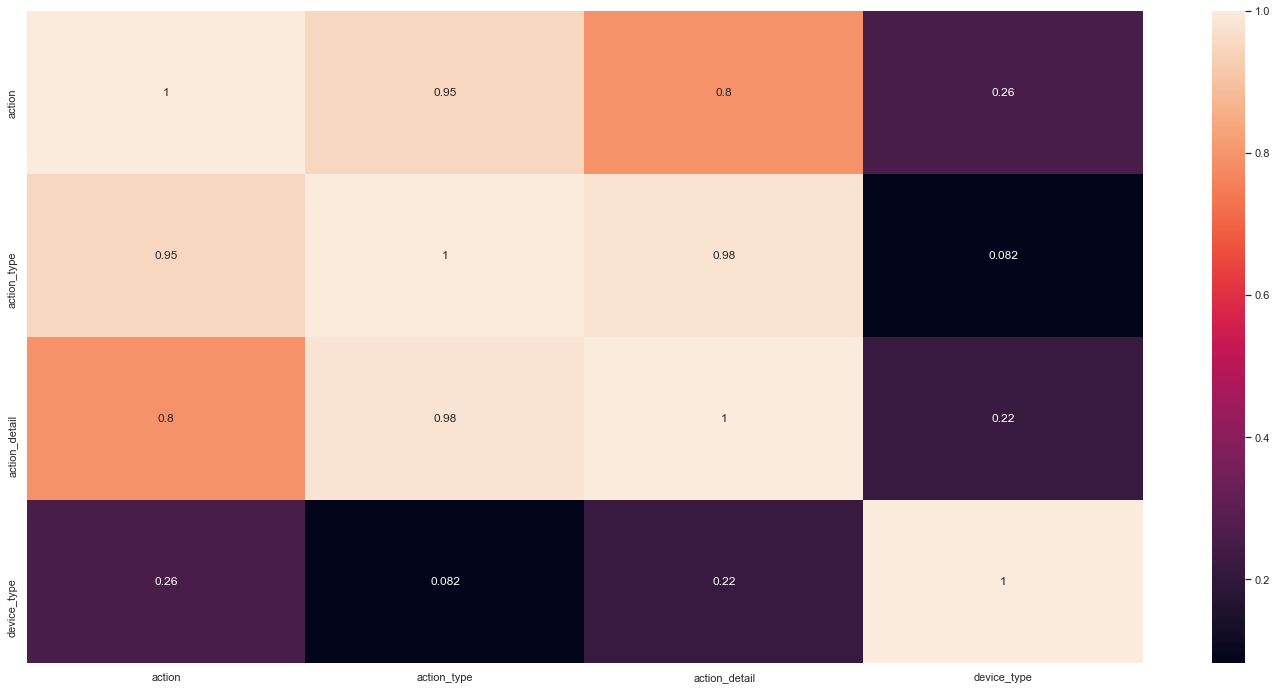

In [31]:
corr_session = pd.DataFrame( corr_dict )
corr_session = corr_session.set_index( corr_session.columns )
sns.heatmap( corr_session, annot=True );

# 2.0. FEATURE ENGINEERING

In [32]:
df2 = df1.copy()

## 2.1. Deriving New Features

In [33]:
# first time activated up to date first booking
df2['first_activation'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime('%Y-%m-%m') )
df2['first_time_activated_up_to_date_first_booking'] = (df2['date_first_booking'] - df2['first_activation']).apply(lambda x: x.days)

# first time activated up to date account created
df2['first_time_activated_up_to_date_account_created'] = (df2['date_account_created'] - df2['first_activation']).apply(lambda x: x.days)

# account created up to date first booking
df2['account_created_up_to_date_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)

############ First Activation ############

# year of first activation
df2['year_first_activation'] = df2['first_activation'].dt.year

# month of first activation
df2['month_first_activation'] = df2['first_activation'].dt.month

# day of first activation
df2['day_first_activation'] = df2['first_activation'].dt.day

# day of week first activation
df2['day_of_week_first_activation'] = df2['first_activation'].dt.dayofweek

# week of year of first activation
df2['week_of_year_first_activation'] = df2['first_activation'].dt.weekofyear

############ First Booking ############

# year of first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month of first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day of first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year of first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

############ Account Created ############

# year of account created
df2['year_account_created'] = df2['date_account_created'].dt.year

# month of account created
df2['month_account_created'] = df2['date_account_created'].dt.month

# day of account created
df2['day_account_created'] = df2['date_account_created'].dt.day

# day of week account_created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year of account created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

In [34]:
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,first_activation,first_time_activated_up_to_date_first_booking,first_time_activated_up_to_date_account_created,account_created_up_to_date_first_booking,year_first_activation,month_first_activation,day_first_activation,day_of_week_first_activation,week_of_year_first_activation,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2009-05-05,2246,750,1496,2009,5,5,1,19,2015,6,29,0,27,2011,5,25,2,21
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2009-06-06,422,479,-57,2009,6,6,5,23,2010,8,2,0,31,2010,9,28,1,39
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2009-10-10,1064,786,278,2009,10,10,5,41,2012,9,8,5,36,2011,12,5,0,49
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2009-12-12,68,276,-208,2009,12,12,5,50,2010,2,18,3,7,2010,9,14,1,37
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,2010-01-01,4,1,3,2010,1,1,4,53,2010,1,5,1,1,2010,1,2,5,53


# 3.0. VARIABLE FILTERING

In [35]:
df3 = df2.copy()

## 3.1. Filtering Rows

In [36]:
df3 = df3[ (df3['age'] > 16 ) & (df3['age'] < 120 ) ]

## 3.2. Columns Selection

# 4.0. FEATURE SELECTION

In [37]:
df4 = df3.copy()

In [38]:
df4_dummy = pd.get_dummies( df4.drop( ['id', 'country_destination'], axis=1 ) )
df4 = pd.concat( [df4[['id', 'country_destination']], df4_dummy ], axis=1 )

In [39]:
df4.shape

(122610, 144)

In [40]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_activation']
df5 = df4.drop( cols_drop , axis=1 )

In [41]:
X = df5.drop( 'country_destination', axis=1 )
y = df5['country_destination'].copy()

In [42]:
# split dataset into training and test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=32 )

# 5.0. MACHINE LEARNING MODEL

In [43]:
# dropping id column
x_train = X_train.drop( 'id', axis=1 )
x_test = X_test.drop( 'id', axis=1 )

In [44]:
x_train.shape

(98088, 138)

## 5.1. Baseline Model

In [45]:
population = df1['country_destination'].drop_duplicates().sort_values().tolist()

In [46]:
weights = df1['country_destination'].value_counts( normalize=True ).sort_index().to_list()

In [47]:
k_num = y_test.shape[0]

In [48]:
yhat_random = choices( population=population, weights=weights, k=k_num )

Accuracy: 0.36%
Balanced Accuracy: 0.08%
Kappa Score: 0.001%
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        80
          CA       0.01      0.01      0.01       209
          DE       0.01      0.01      0.01       181
          ES       0.01      0.01      0.01       354
          FR       0.03      0.03      0.03       726
          GB       0.02      0.02      0.02       369
          IT       0.01      0.01      0.01       383
         NDF       0.45      0.45      0.45     10980
          NL       0.00      0.00      0.00       125
          PT       0.00      0.00      0.00        30
          US       0.39      0.39      0.39      9564
       other       0.07      0.07      0.07      1521

    accuracy                           0.36     24522
   macro avg       0.08      0.08      0.08     24522
weighted avg       0.36      0.36      0.36     24522



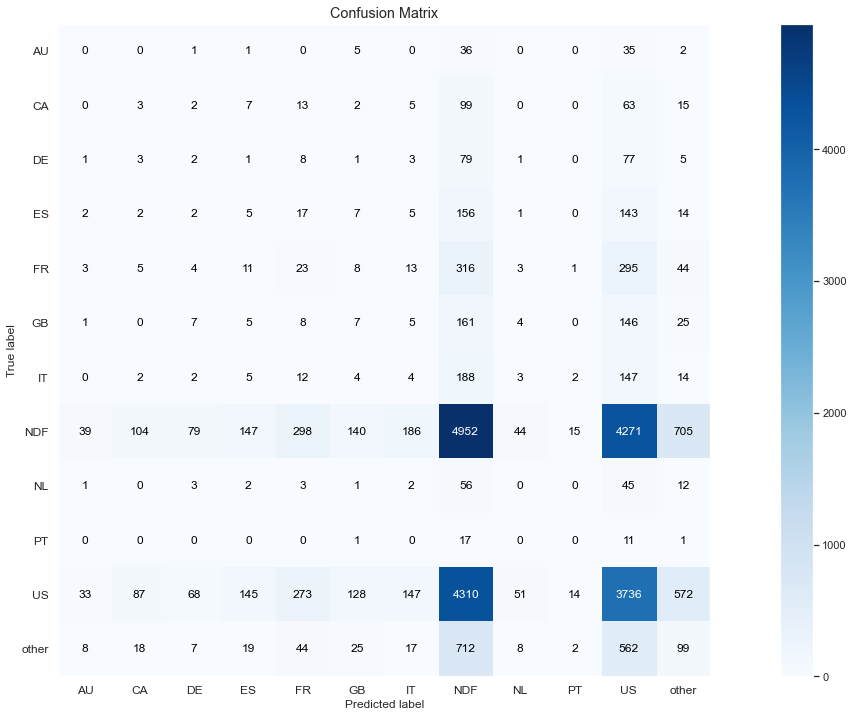

In [49]:
# Accuracy
accuracy_random = accuracy_score( y_test, yhat_random )
print(f'Accuracy: {accuracy_random:.2f}%')

# Balanced Accuracy
balanced_accuracy_random = balanced_accuracy_score( y_test, yhat_random )
print(f'Balanced Accuracy: {balanced_accuracy_random:.2f}%')

# Kappa Score
kappa_random = cohen_kappa_score( y_test, yhat_random )
print(f'Kappa Score: {kappa_random:.3f}%')

# Classification Report
print( classification_report( y_test, yhat_random ) )

# Confusion Matrix
plot_confusion_matrix( y_test, yhat_random, normalize=False );

## 5.2. Neural Network - MLP

In [50]:
# One Hot Encoder
one_hot_encod = OneHotEncoder()
y_train_nn = one_hot_encod.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [61]:
print(f'Number of rows: {x_train.shape[0]}')
print(f'Number of columns: {x_train.shape[1]}')
print(f'Number of classes: {y_train.nunique()}')

Number of rows: 98088
Number of columns: 138
Number of classes: 12


In [52]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 256 ,input_dim=x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 12, activation='softmax' ) )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam' , metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

Epoch 1/100
3066/3066 [==============================] - 5s 2ms/step - loss: 6.5995 - accuracy: 0.7310
Epoch 2/100
3066/3066 [==============================] - 5s 2ms/step - loss: 2.5636 - accuracy: 0.7544
Epoch 3/100
3066/3066 [==============================] - 4s 1ms/step - loss: 1.2939 - accuracy: 0.7836
Epoch 4/100
3066/3066 [==============================] - 5s 2ms/step - loss: 0.9155 - accuracy: 0.8081
Epoch 5/100
3066/3066 [==============================] - 5s 2ms/step - loss: 0.7366 - accuracy: 0.8294
Epoch 6/100
3066/3066 [==============================] - 5s 2ms/step - loss: 0.6709 - accuracy: 0.8377
Epoch 7/100
3066/3066 [==============================] - 6s 2ms/step - loss: 0.6480 - accuracy: 0.8383
Epoch 8/100
3066/3066 [==============================] - 8s 3ms/step - loss: 0.6453 - accuracy: 0.8383
Epoch 9/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6415 - accuracy: 0.8384
Epoch 10/100
3066/3066 [==============================] - 6s 2ms/step - l

3066/3066 [==============================] - 4s 1ms/step - loss: 0.6331 - accuracy: 0.8392
Epoch 78/100
3066/3066 [==============================] - 5s 1ms/step - loss: 0.6340 - accuracy: 0.8391: 0s - loss: 0.6346 - 
Epoch 79/100
3066/3066 [==============================] - 5s 2ms/step - loss: 0.6330 - accuracy: 0.8392
Epoch 80/100
3066/3066 [==============================] - 5s 2ms/step - loss: 0.6352 - accuracy: 0.8390
Epoch 81/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6325 - accuracy: 0.8393
Epoch 82/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6328 - accuracy: 0.8392
Epoch 83/100
3066/3066 [==============================] - 5s 2ms/step - loss: 0.6331 - accuracy: 0.8392
Epoch 84/100
3066/3066 [==============================] - 6s 2ms/step - loss: 0.6333 - accuracy: 0.8391
Epoch 85/100
3066/3066 [==============================] - 6s 2ms/step - loss: 0.6328 - accuracy: 0.8393: 0s - loss: 0.6331  - ETA: 0s - los
Epoch 86/100
3066/3

### 5.2.1. NN PERFORMANCE

In [53]:
# prediction
y_test_nn = model.predict( x_test )

# invert 
yhat_nn = one_hot_encod.inverse_transform( y_test_nn )

# prediction preparation
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

In [54]:
# Accuracy
accuracy_nn = accuracy_score( y_test_nn, yhat_nn )
print(f'Accuracy: {accuracy_nn:.2f}%')

# Balanced Accuracy
balanced_accuracy_nn = balanced_accuracy_score( y_test_nn, yhat_nn )
print(f'Balanced Accuracy: {balanced_accuracy_nn:.2f}%')

# Kappa Score
kappa_nn = cohen_kappa_score( y_test_nn, yhat_nn )
print(f'Kappa Score: {kappa_nn:.3f}%')

Accuracy: 0.84%
Balanced Accuracy: 0.17%
Kappa Score: 0.722%


In [55]:
# Classification Report
print( classification_report( y_test_nn, yhat_nn ) )

              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        80
          CA       0.00      0.00      0.00       209
          DE       0.00      0.00      0.00       181
          ES       0.00      0.00      0.00       354
          FR       0.00      0.00      0.00       726
          GB       0.00      0.00      0.00       369
          IT       0.00      0.00      0.00       383
         NDF       1.00      1.00      1.00     10980
          NL       0.00      0.00      0.00       125
          PT       0.00      0.00      0.00        30
          US       0.71      1.00      0.83      9564
       other       0.00      0.00      0.00      1521

    accuracy                           0.84     24522
   macro avg       0.14      0.17      0.15     24522
weighted avg       0.72      0.84      0.77     24522



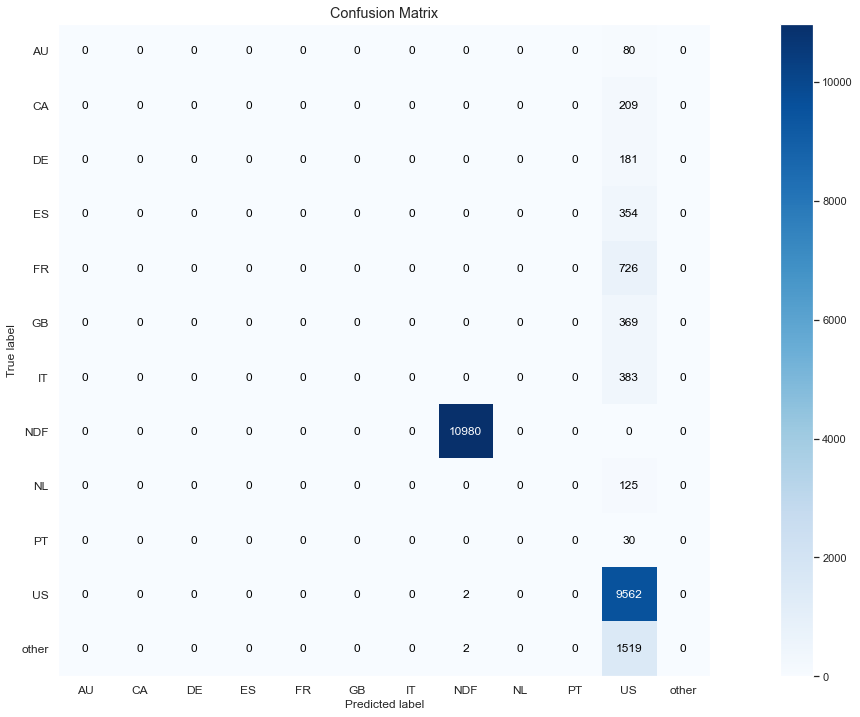

In [56]:
# Confusion Matrix
plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False );

### 5.2.2. NN PERFORMANCE - Cross Validation

In [57]:
# generate kfold
n_folds = 5
kfold = StratifiedKFold( n_splits=n_folds, shuffle=True, random_state=32 )
balanced_accuracy_nn_list = []
kappa_score_list = []
i = 1

for train_ix, val_ix in kfold.split( x_train, y_train ):
    print(f'Kfold Number: {i}/{n_folds}')

    # get kfold
    x_train_fold = x_train.iloc[ train_ix ]
    y_train_fold = y_train.iloc[ train_ix ]
    
    x_val_fold = x_train.iloc[ val_ix ]
    y_val_fold = y_train.iloc[ val_ix ]

    # One Hot Encoder
    one_hot_encoder = OneHotEncoder()
    y_train_fold_nn = one_hot_encoder.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # Model Definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 12, activation='softmax' ) )

    # Compile
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # Training
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=False )

    # Prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = one_hot_encoder.inverse_transform( pred_nn )
    
    # Data preparation
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # Metrics
    ## Balanced Accuracy
    balanced_accuracy_nn = balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_accuracy_nn_list.append( balanced_accuracy_nn )

    ## Kappa Score
    kappa_score_nn = cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_score_list.append( kappa_score_nn )
    
    i += 1


Kfold Number: 1/5
Kfold Number: 2/5
Kfold Number: 3/5
Kfold Number: 4/5
Kfold Number: 5/5


In [58]:
print(f'Average Balanced Accuracy: { round(np.mean( balanced_accuracy_nn_list ), 2 ) } +/- { round(np.std( balanced_accuracy_nn_list ), 3)  }')

Average Balanced Accuracy: 0.17 +/- 0.0


In [59]:
print(f'Average Kappa Score: { round(np.mean( kappa_score_list ), 3) } +/- { round(np.std( kappa_score_list ), 3) }')

Average Kappa Score: 0.724 +/- 0.0
